In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from analysis import *
import glob
import re
import hvplot.xarray
font = {'family':'serif',
        'weight': 'normal',
        'size': 32}
plt.rc('font',**font)
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#000000','#e3130f','#0962f6',
                                                    '#20c168','#fc76f3','#2efef4'])
plt.rc('text',usetex=True)

In [2]:
hbar = 1.055e-34
e = 1.6e-19
mu0 = np.pi*4*1e-7
Ms = 0.9/mu0
tpt = 4e-9
SA2xi = e*mu0*Ms*tpt/hbar #missing tco still

In [3]:
def load_file(f):
    return pd.read_csv(f,comment='#').set_index('field_azimuth').drop(columns='elapsed_time').to_xarray()
def find_dev(f):
    z = re.compile('./saba/(?P<d>C\dR\d).*')
    return re.match(z,f)['d']
atop = combine_new_dim({find_dev(f):load_file(f) for f in glob.glob('./saba/*2x05*Hall*')}, 'dev')
abot = combine_new_dim({find_dev(f):load_file(f) for f in glob.glob('./saba/*6x05*Hall*')}, 'dev')
a = combine_new_dim({'top':atop,'bottom':abot},'pos')

In [4]:
def sin2(x,x0,a,b):
    return np.sin(2*np.pi/180.*(x-x0))*a + b
def sin2_guess(*args,**kwargs):
    return [1,1,1]
phe_fit = fit_dataArray(a.X1,sin2,sin2_guess,['phi0','a','b'],'field_azimuth')
def harm2(x,x0,a,b,c):
    return a*np.cos(2*np.pi/180.*(x-x0))*np.cos(np.pi/180.*(x-x0)) + b*np.cos(np.pi/180.*(x-x0)) + c
def harm2_guess(*args,**kwargs):
    return [1,1,1,1]
harm_fit = fit_dataArray(a.Y2,harm2,harm2_guess,['phi0','a','b','c'],'field_azimuth')

In [22]:
meff_fit.sel(dev='C5R8', pos='top',leads='l')

<xarray.Dataset>
Dimensions:        (field_azimuth: 1)
Coordinates:
    dev            <U4 'C5R8'
  * field_azimuth  (field_azimuth) float64 45.0
    pos            <U6 'top'
    leads          <U1 'l'
Data variables:
    Meff           (field_azimuth) float64 1.174
    Meff_err       (field_azimuth) float64 0.01145

Text(0, 0.5, '$V^{2\\omega}_{XY}$ ($\\mu$V)')

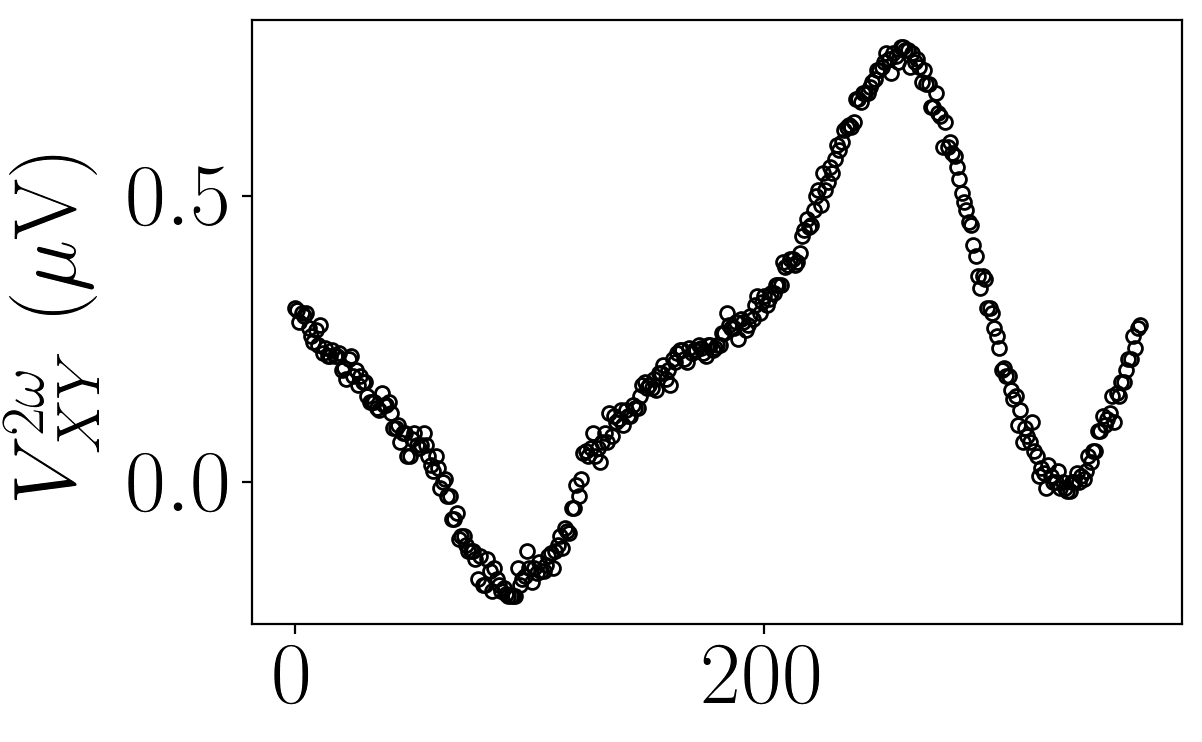

In [23]:
plt.figure(dpi=200)
plt.errorbar(a.sel(dev='C5R8', pos='top').field_azimuth, a.sel(dev='C5R8', pos='top').Y2*1e6,
             fmt='o',linestyle='none',ms=5,capsize=8,fillstyle='none',color = 'C0')

plt.ylabel('$V^{2\\omega}_{XY}$ ($\\mu$V)')

In [5]:
def load_stfmr(f):
    stfmr = STFMRAnalysis()
    stfmr.load_sweep('./saba/',series_file=[f])
    return stfmr
bottom = combine_new_dim({find_dev(f):load_stfmr(f.split('/')[2]) \
                          for f in glob.glob('./saba/*6x05*_1.txt')},'dev')
top = combine_new_dim({find_dev(f):load_stfmr(f.split('/')[2]) \
                          for f in glob.glob('./saba/*2x05*_1.txt')},'dev')
stfmr = HallSTFMRAnalysis
stfmr.sweep_ds = combine_new_dim({'top':top,'bottom':bottom},'pos')

In [18]:
def lor(B,B0,Delta,S,A,C):
    return S*Delta**2/((B-B0)**2 + Delta**2) + A*(B-B0)*Delta/((B-B0)**2 + Delta**2) + C
def lor_guess(*args,**kwargs):
    return [0.1,0.05,1e-7,1e-7,0]
l = fit_dataArray(stfmr.sweep_ds.X,lor,lor_guess,['B0','Delta','S','A','C'],'field_strength',maxfev=10000)
t = fit_dataArray(stfmr.sweep_ds.Xt,lor,lor_guess,['B0','Delta','S','A','C'],'field_strength',maxfev=10000)
stfmr_fit = combine_new_dim({'l':l,'t':t},'leads')

In [19]:
def B0(f, Meff):
    w = 2*np.pi*f
    return 0.5*(-Meff + np.sqrt(Meff**2 + 4*w**2/(2*np.pi*28.024)**2))
def B0_guess(*args,**kwargs):
    return [1]
meff_fit = fit_dataArray(stfmr_fit.B0,B0,B0_guess,['Meff'],'rf_freq',bounds=((0),np.inf))
# meff_fit.hvplot('dev','Meff')

<ErrorbarContainer object of 3 artists>

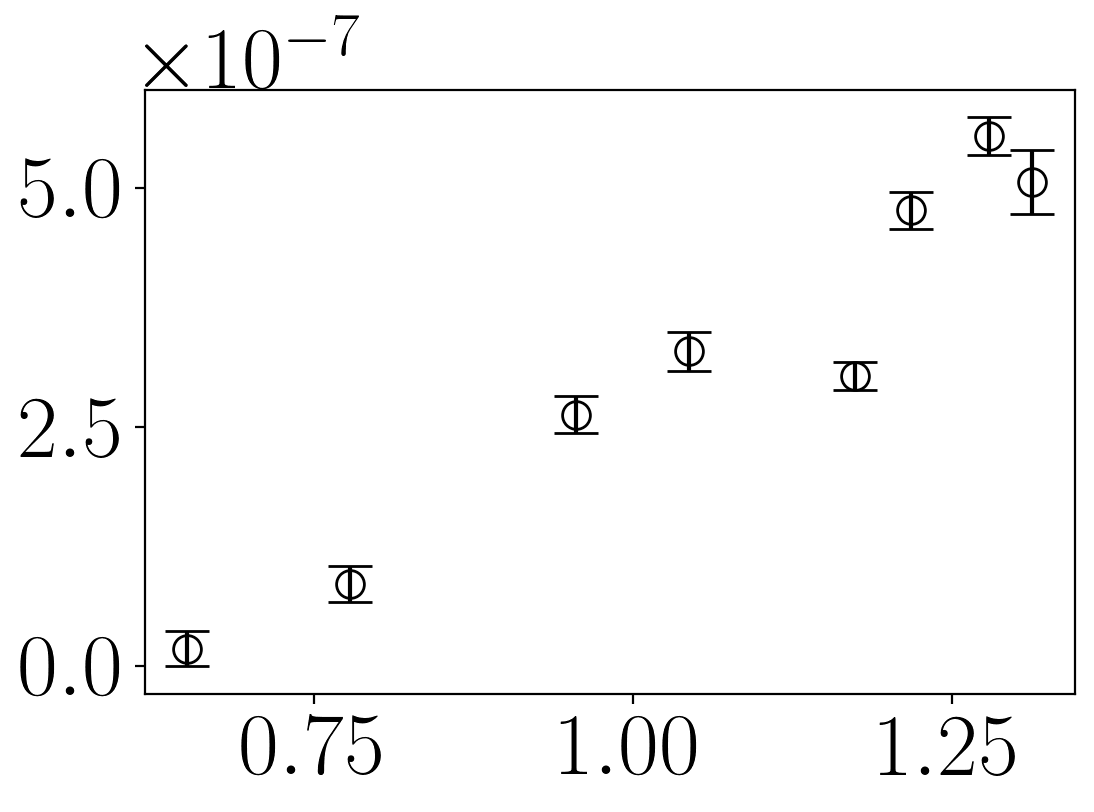

In [8]:
plt.figure(dpi=200)
plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
             abs(harm_fit.a).values.flatten(),
             abs(harm_fit.a_err).values.flatten(),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')

In [9]:
def load_stfmr(f):
    stfmr = STFMRAnalysis()
    stfmr.load_sweep('./saba/',series_file=[f])
    return stfmr
bottom = combine_new_dim({find_dev(f):load_stfmr(f.split('/')[2]) \
                          for f in glob.glob('./saba/*6x05*_2.txt')},'dev')
top = combine_new_dim({find_dev(f):load_stfmr(f.split('/')[2]) \
                          for f in glob.glob('./saba/*2x05*_2.txt')},'dev')
ang = HallSTFMRAnalysis()
ang.sweep_ds = combine_new_dim({'top':top,'bottom':bottom},'pos')
ang225 = ang.sweep_ds.where(ang.field_strength<0, drop = True)
ang225['field_azimuth'] = ang225['field_azimuth'] + 180
ang225['field_strength'] = -1*ang225['field_strength']
ang45 = ang.sweep_ds.where(ang.field_strength>0, drop = True)

ang = xr.concat([ang45,ang225],'field_azimuth')
ang['field_azimuth'] = 270-ang['field_azimuth']
ang = ang.where(ang.field_strength>0.02)
l = fit_dataArray(ang.X,lor,lor_guess,['B0','Delta','S','A','C'],'field_strength',maxfev=100000,
                  bounds=((0,0,-np.inf,-np.inf,-np.inf),np.inf))
t = fit_dataArray(ang.Xt,lor,lor_guess,['B0','Delta','S','A','C'],'field_strength',maxfev=100000,
                  bounds=((0,0,-np.inf,-np.inf,-np.inf),np.inf))
ang_fit = combine_new_dim({'l':l,'t':t},'leads')

In [10]:
ang_fit = ang_fit.where(ang_fit.field_azimuth != 0,drop =True).where(ang_fit.field_azimuth != 345,drop =True)

In [11]:
def l_ang(x,x0,a,b):
    return a*np.sin(2*np.pi/180*(x-x0))*np.cos(np.pi/180*(x-x0)) + b
def l_ang_guess(*args,**kwargs):
    return [0,1e-5,0]
l_Sfit = fit_dataArray(ang_fit.sel(leads='l').S,l_ang,l_ang_guess,['phi0','a','b'],'field_azimuth',maxfev=10000)
l_Afit = fit_dataArray(ang_fit.sel(leads='l').A,l_ang,l_ang_guess,['phi0','a','b'],'field_azimuth',maxfev=10000)
t_Sfit = fit_dataArray(ang_fit.sel(leads='t').S,harm2,harm2_guess,['phi0','a','b','c'],'field_azimuth')
t_Afit = fit_dataArray(ang_fit.sel(leads='t').A,harm2,harm2_guess,['phi0','a','b','c'],'field_azimuth')

No handles with labels found to put in legend.


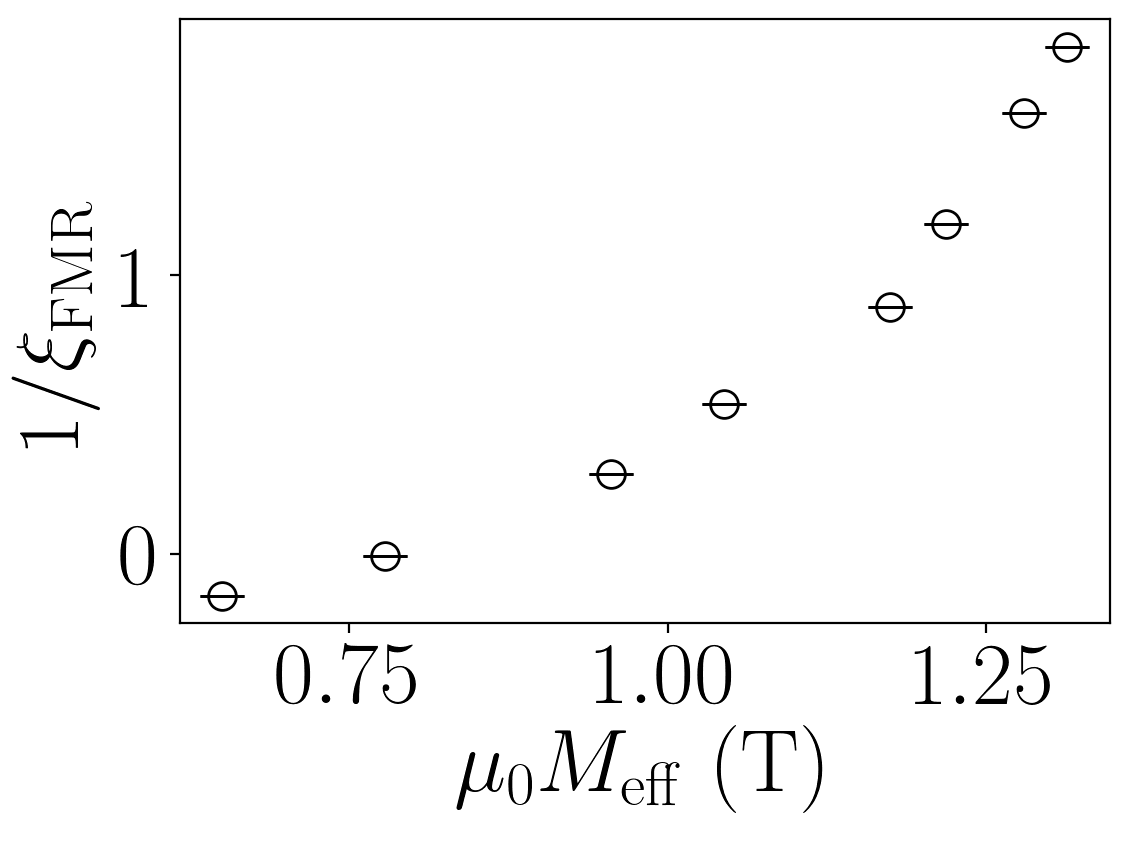

In [12]:
# plt.figure(dpi=200)
# plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
#              abs(l_Afit.mean('rf_freq').a).values.flatten(),
#              abs(l_Afit.mean('rf_freq').a_err).values.flatten(),
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
#              label='AMR A amplitude')
# plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
#              abs(l_Sfit.mean('rf_freq').a).values.flatten(),
#              abs(l_Sfit.mean('rf_freq').a_err).values.flatten(),
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
#              label='AMR S amplitude')
# plt.legend(loc='center left',bbox_to_anchor=[0,0.5],frameon=False,fontsize=17,
#            ncol=1,handlelength=1,columnspacing=0.8,handletextpad=0.3)

plt.figure(dpi=200)
plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
             1/(l_Sfit.mean('rf_freq').a.values.flatten()/l_Afit.mean('rf_freq').a.values.flatten()),
             0*abs(l_Afit.mean('rf_freq').a_err).values.flatten(),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.ylabel('$1/\\xi_{\\rm{FMR}}$')
plt.xlabel('$\\mu_0 M_{\\rm{eff}}$ (T)')

plt.legend(loc='center left',bbox_to_anchor=[0,0.5],frameon=False,fontsize=17,
           ncol=1,handlelength=1,columnspacing=0.8,handletextpad=0.3)

Text(0.5, 0, '$\\mu_0 M_{\\rm{eff}}$ (T)')

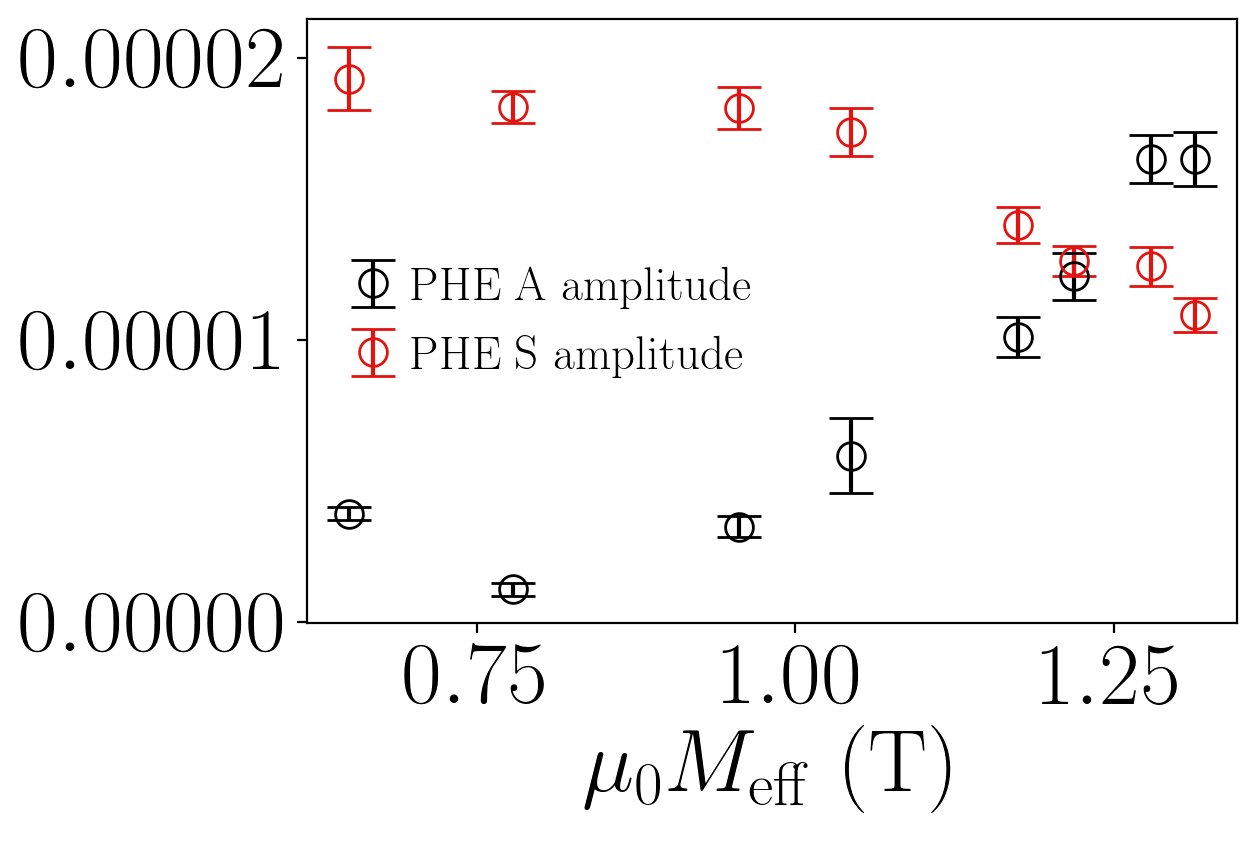

In [13]:
plt.figure(dpi=200)
plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
             abs(t_Afit.mean('rf_freq').a).values.flatten(),
             abs(t_Afit.mean('rf_freq').a_err).values.flatten(),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label='PHE A amplitude')
plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
             abs(t_Sfit.mean('rf_freq').a).values.flatten(),
             abs(t_Sfit.mean('rf_freq').a_err).values.flatten(),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='PHE S amplitude')
plt.legend(loc='center left',bbox_to_anchor=[0,0.5],frameon=False,fontsize=17,
           ncol=1,handlelength=1,columnspacing=0.8,handletextpad=0.3)
# plt.ylabel('$1/\\xi_{\\rm{FMR}}$')
plt.xlabel('$\\mu_0 M_{\\rm{eff}}$ (T)')

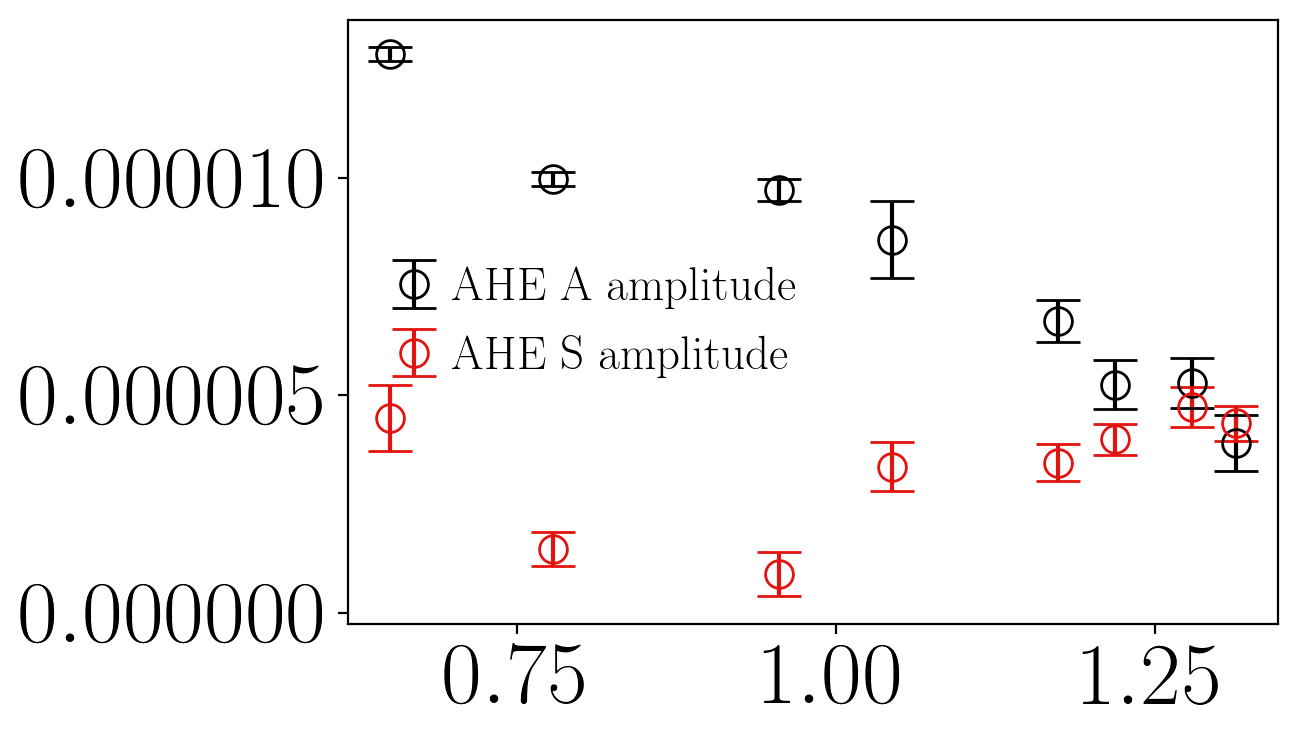

In [14]:
plt.figure(dpi=200)
plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
             abs(t_Afit.mean('rf_freq').b).values.flatten(),
             abs(t_Afit.mean('rf_freq').b_err).values.flatten(),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label='AHE A amplitude')
plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
             abs(t_Sfit.mean('rf_freq').b).values.flatten(),
             abs(t_Sfit.mean('rf_freq').b_err).values.flatten(),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='AHE S amplitude')
plt.legend(loc='center left',bbox_to_anchor=[0,0.5],frameon=False,fontsize=17,
           ncol=1,handlelength=1,columnspacing=0.8,handletextpad=0.3)

In [15]:
def Meff_to_t(m):
    return (2.7)/(1.3)*m*1e-9 + 2*1e-9

In [16]:
Meff_to_t(0.6)

3.2461538461538463e-09

In [17]:
ang_fit.B0.sel(leads='l',field_azimuth=45).mean('rf_freq')

<xarray.DataArray 'B0' (pos: 2, dev: 4)>
array([[0.1171934 , 0.10351634, 0.10319318, 0.09273155],
       [0.10030964, 0.09510919, 0.09769573, 0.090265  ]])
Coordinates:
    field_azimuth  float64 45.0
  * dev            (dev) <U4 'C5R6' 'C5R7' 'C5R8' 'C5R9'
  * pos            (pos) <U6 'top' 'bottom'
    leads          <U1 'l'

In [18]:
(l_Sfit.mean('rf_freq').a.values.flatten()/l_Afit.mean('rf_freq').a.values.flatten()*\
             SA2xi*Meff_to_t(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten())*\
             np.sqrt(1 + meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten()/\
                  ang_fit.B0.sel(leads='l',field_azimuth=45).mean('rf_freq').values.flatten()))

array([-0.31478942,  0.24317704,  0.09605521,  0.06187098, -8.6102753 ,
        0.14606717,  0.07675826,  0.05597584])

0.022354392844796636


(0, 0.35)

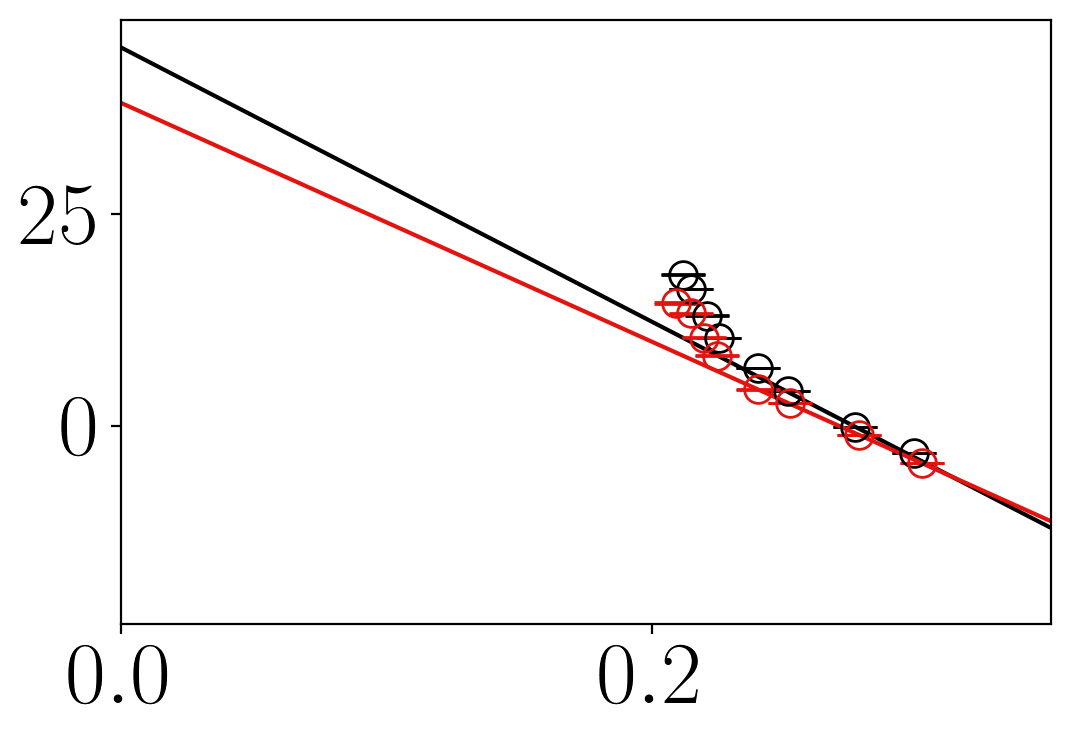

In [19]:
plt.figure(dpi=200)
x = 1/Meff_to_t(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten())*1e-9
y = 1/(l_Sfit.mean('rf_freq').a.values.flatten()/l_Afit.mean('rf_freq').a.values.flatten()*\
             SA2xi*Meff_to_t(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten())*\
             np.sqrt(1 + meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten()/\
                  ang_fit.B0.sel(leads='l',field_azimuth=45).mean('rf_freq').values.flatten()))
y_err = l_Afit.mean('rf_freq').a.values.flatten()/l_Sfit.mean('rf_freq').a.values.flatten()*\
             np.sqrt((l_Afit.mean('rf_freq').a_err.values.flatten()/l_Afit.mean('rf_freq').a.values.flatten())**2+
                     (l_Sfit.mean('rf_freq').a_err.values.flatten()/l_Sfit.mean('rf_freq').a.values.flatten())**2)
plt.errorbar(x,y,y_err,fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
popt,pcov = np.polyfit(x[np.where(x>0.25)],y[np.where(x>0.25)],1,w=1/y_err[np.where(x>0.25)]**2,cov=True)
plt.plot([0,0.4],np.polyval(popt,[0,0.4]))
plt.xlim(0,0.35)
print(1/popt[1])

x = 1/Meff_to_t(meff_fit.sel(leads='t',field_azimuth=45).Meff.values.flatten())*1e-9
y= 1/(t_Sfit.mean('rf_freq').a.values.flatten()/t_Afit.mean('rf_freq').a.values.flatten()*\
             SA2xi*Meff_to_t(meff_fit.sel(leads='t',field_azimuth=45).Meff.values.flatten())*\
             np.sqrt(1 + meff_fit.sel(leads='t',field_azimuth=45).Meff.values.flatten()/\
                  ang_fit.B0.sel(leads='t',field_azimuth=45).mean('rf_freq').values.flatten()))
y_err = t_Afit.mean('rf_freq').a.values.flatten()/t_Sfit.mean('rf_freq').a.values.flatten()*\
             np.sqrt((t_Afit.mean('rf_freq').a_err.values.flatten()/t_Afit.mean('rf_freq').a.values.flatten())**2+
                     (t_Sfit.mean('rf_freq').a_err.values.flatten()/t_Sfit.mean('rf_freq').a.values.flatten())**2)
plt.errorbar(x,y,y_err,fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')
popt,pcov = np.polyfit(x[np.where(x>0.25)],y[np.where(x>0.25)],1,w=1/y_err[np.where(x>0.25)]**2,cov=True)
plt.plot([0,0.4],np.polyval(popt,[0,0.4]),'C1')
plt.xlim(0,0.35)

<ErrorbarContainer object of 3 artists>

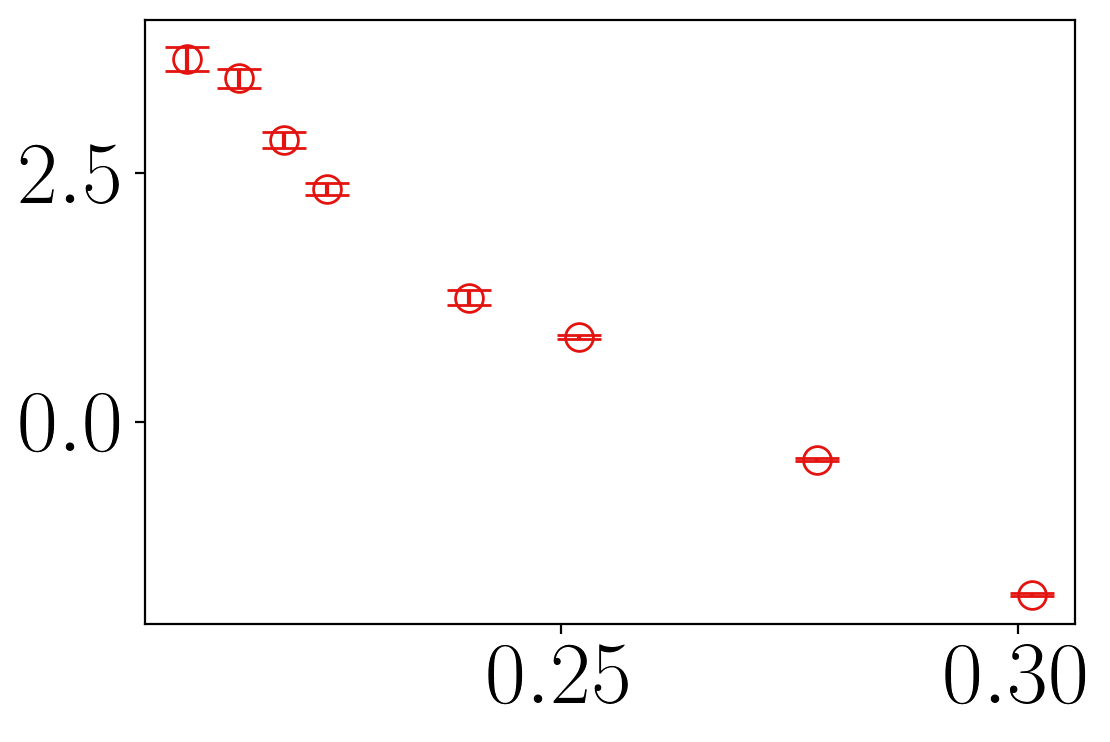

In [20]:
plt.figure(dpi=200)
plt.errorbar(1/Meff_to_t(meff_fit.sel(leads='t',field_azimuth=45).Meff.values.flatten())*1e-9,
             1/(t_Sfit.mean('rf_freq').a.values.flatten()/t_Afit.mean('rf_freq').a.values.flatten()*\
             SA2xi*Meff_to_t(meff_fit.sel(leads='t',field_azimuth=45).Meff.values.flatten())*\
             (1 + meff_fit.sel(leads='t',field_azimuth=45).Meff.values.flatten()/\
                  ang_fit.B0.sel(leads='t',field_azimuth=45).mean('rf_freq').values.flatten())),
             t_Afit.mean('rf_freq').a.values.flatten()/t_Sfit.mean('rf_freq').a.values.flatten()*\
             np.sqrt((t_Afit.mean('rf_freq').a_err.values.flatten()/t_Afit.mean('rf_freq').a.values.flatten())**2+
                     (t_Sfit.mean('rf_freq').a_err.values.flatten()/t_Sfit.mean('rf_freq').a.values.flatten())**2),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')

<ErrorbarContainer object of 3 artists>

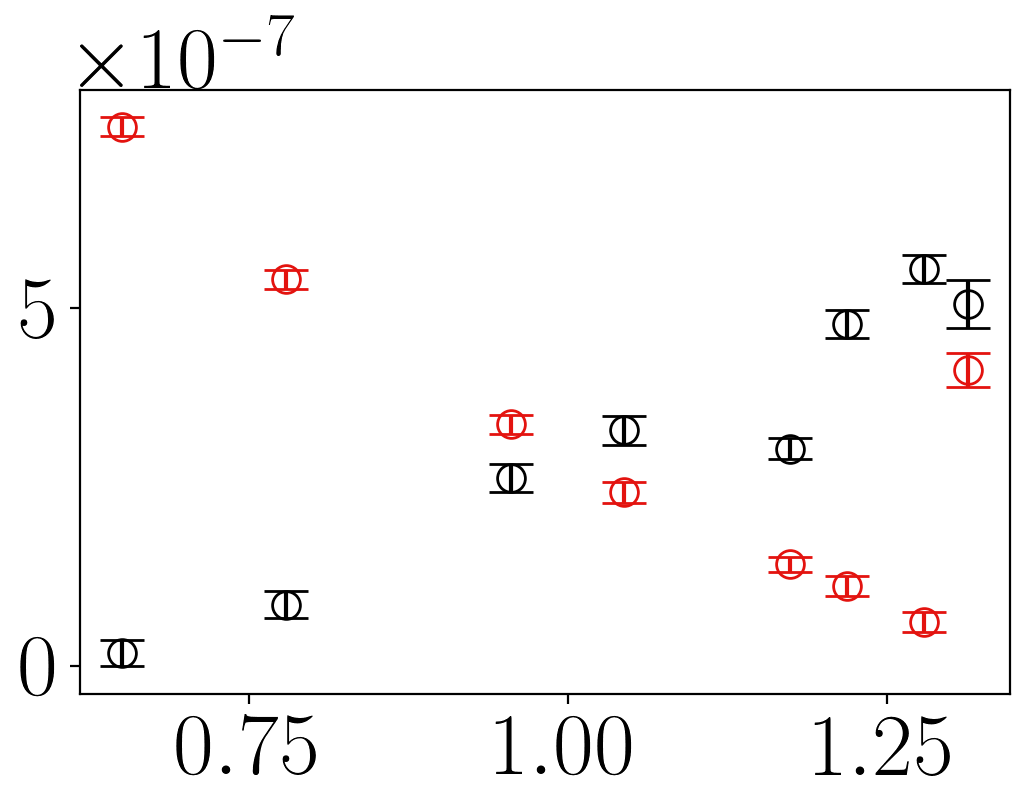

In [21]:
plt.figure(dpi=200)
plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
             abs(harm_fit.a).values.flatten(),
             abs(harm_fit.a_err).values.flatten(),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.errorbar(meff_fit.sel(leads='l',field_azimuth=45).Meff.values.flatten(),
             abs(harm_fit.b).values.flatten(),
             abs(harm_fit.b_err).values.flatten(),
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')